In [1]:
import xgboost as xgb   # model training
from xgboost.sklearn import XGBRegressor
import pickle           # save model
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import metrics   # Additional scklearn functions

from matplotlib.pylab import rcParams
import matplotlib.pylab as plt
%matplotlib inline

ref: https://blog.csdn.net/weiyongle1996/article/details/78360873

In [2]:
%run 101-data_preprocessing.py

In [5]:
default_params = {
    'learning_rate': 0.1,
    'n_estimators': 500,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree':0.8,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'objective': 'reg:squarederror'
}

In [ ]:
def model_fit(model: xgb.XGBRegressor or xgb.XGBRegressor, 
              X: pd.DataFrame or np.array or list, 
              y: pd.DataFrame or np.array or list, 
              useTrainCV=True,
              cv_folds=5,
              early_stopping_rounds=50
              ) -> None:
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=model.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval=True
                          )
        model.set_params(n_estimators=cvresult.shape[0])

    # fit the algorithm on the data
    model.fit(X, y, eval_metric='rmse')
    
    # predict training set
    dtrain_predictions = model.predict(X)
    dtrain_predprob = model.predict_proba(X)[:,1]
    
    # print model report
    print('*'*10)
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
    print('*'*10)
    
    sns.set_style('whitegrid')
    feat_imp = (pd.Series(model.get_booster().get_fscore())
                .sort_values(ascending=False))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    return model

## 1 - Confirm the parameters by cross-validation

[0]	train-auc:0.75493+0.02268	test-auc:0.74102+0.01712
[1]	train-auc:0.82874+0.00452	test-auc:0.80357+0.00511
[2]	train-auc:0.84421+0.00367	test-auc:0.81766+0.01060
[3]	train-auc:0.85885+0.00503	test-auc:0.82846+0.01312
[4]	train-auc:0.86455+0.00604	test-auc:0.83248+0.01189
[5]	train-auc:0.86983+0.00318	test-auc:0.83496+0.00924
[6]	train-auc:0.87338+0.00351	test-auc:0.83578+0.01026
[7]	train-auc:0.87799+0.00317	test-auc:0.83912+0.00951
[8]	train-auc:0.88140+0.00307	test-auc:0.84113+0.00907
[9]	train-auc:0.88520+0.00350	test-auc:0.84131+0.00950
[10]	train-auc:0.88685+0.00324	test-auc:0.84279+0.00837
[11]	train-auc:0.89061+0.00298	test-auc:0.84332+0.00865
[12]	train-auc:0.89311+0.00274	test-auc:0.84456+0.00840
[13]	train-auc:0.89494+0.00367	test-auc:0.84596+0.00846
[14]	train-auc:0.89865+0.00427	test-auc:0.84907+0.00932
[15]	train-auc:0.90212+0.00435	test-auc:0.85177+0.00988
[16]	train-auc:0.90393+0.00367	test-auc:0.85232+0.00942
[17]	train-auc:0.90593+0.00334	test-auc:0.85323+0.00870
[1

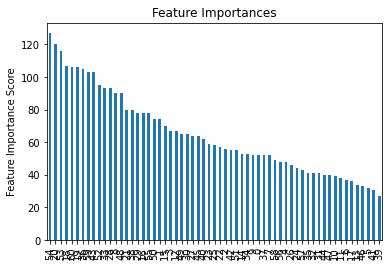

In [37]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=3612
 )

xgb2 = model_fit(xgb1, X_train, y_train_t1)

In [38]:
print('best n_estimators:', xgb2.get_params()['n_estimators'])
print('best max_depth:', xgb2.get_params()['max_depth'])
print('best min_child_weight:', xgb2.get_params()['min_child_weight'])
print('best gamma:', xgb2.get_params()['gamma'])
print('best subsample:', xgb2.get_params()['subsample'])
print('best colsample_bytree:', xgb2.get_params()['colsample_bytree'])


best n_estimators: 161
best max_depth: 5
best min_child_weight: 1
best gamma: 0
best subsample: 0.8
best colsample_bytree: 0.8


best n_estimators: 161

## 2 - Optimize `max_depth` and `min_child_weight` by grid search

In [47]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1, 
                                                  n_estimators=161, 
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test1, 
                        scoring='roc_auc', 
                        n_jobs=4, 
                        cv=5
                        )

gsearch1.fit(X_train, y_train_t1)
gsearch1.cv_results_, gsearch1.best_score_, gsearch1.best_params_

({'mean_fit_time': array([12.94007473, 12.48627787, 13.71366358, 26.79241381, 26.87811527,
         22.98863287, 33.97356982, 35.73426452, 35.72936449, 64.63082733,
         50.5218152 , 34.82254543]),
  'std_fit_time': array([0.50779245, 0.86039089, 0.11741125, 1.31196346, 1.0510442 ,
         2.34490988, 1.75515544, 1.72558032, 4.21771144, 2.49621703,
         2.96701757, 3.24200257]),
  'mean_score_time': array([0.0302856 , 0.0329895 , 0.03795462, 0.03869681, 0.0417942 ,
         0.0350872 , 0.04223642, 0.03866901, 0.10632925, 0.08462815,
         0.0977725 , 0.04569297]),
  'std_score_time': array([0.00388471, 0.00552442, 0.0097401 , 0.00669577, 0.00569258,
         0.00722259, 0.00670551, 0.00757805, 0.09134801, 0.06410718,
         0.0642157 , 0.00758223]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [58]:
means = gsearch1.cv_results_["mean_test_score"]
stdevs = gsearch1.cv_results_["std_test_score"]
params = gsearch1.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.885600 (0.026642) with: {'max_depth': 3, 'min_child_weight': 1}
0.884131 (0.026302) with: {'max_depth': 3, 'min_child_weight': 3}
0.885436 (0.026580) with: {'max_depth': 3, 'min_child_weight': 5}
0.883456 (0.025025) with: {'max_depth': 5, 'min_child_weight': 1}
0.885976 (0.023353) with: {'max_depth': 5, 'min_child_weight': 3}
0.886932 (0.021506) with: {'max_depth': 5, 'min_child_weight': 5}
0.883413 (0.024169) with: {'max_depth': 7, 'min_child_weight': 1}
0.881667 (0.027232) with: {'max_depth': 7, 'min_child_weight': 3}
0.885307 (0.027268) with: {'max_depth': 7, 'min_child_weight': 5}
0.885754 (0.024192) with: {'max_depth': 9, 'min_child_weight': 1}
0.884425 (0.024831) with: {'max_depth': 9, 'min_child_weight': 3}
0.885448 (0.023637) with: {'max_depth': 9, 'min_child_weight': 5}


In [49]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate=0.1,
                                                  n_estimators=161,
                                                  max_depth=5,
                                                  min_child_weight=2, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test2, 
                        scoring='roc_auc', 
                        n_jobs=4,
                        cv=5
                        )

gsearch2.fit(X_train,y_train_t1)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_


({'mean_fit_time': array([14.94463863, 18.04925337, 18.28529296, 21.84272571, 20.21747408,
         18.68082519, 40.78213081, 44.61673346, 30.7163034 ]),
  'std_fit_time': array([1.39230841, 0.32268962, 0.19287103, 0.63453459, 2.31400717,
         3.94599966, 8.58772699, 2.26150308, 9.74102315]),
  'mean_score_time': array([0.03808627, 0.04003773, 0.03517241, 0.04013047, 0.03263903,
         0.03535838, 0.06857553, 0.06185479, 0.03755202]),
  'std_score_time': array([0.00622615, 0.00579293, 0.00928699, 0.00874823, 0.00354734,
         0.00742067, 0.04128233, 0.01478953, 0.00720388]),
  'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[4, 5, 6, 4, 5, 6, 4, 5, 6],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [59]:
means = gsearch2.cv_results_["mean_test_score"]
stdevs = gsearch2.cv_results_["std_test_score"]
params = gsearch2.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.887045 (0.024516) with: {'max_depth': 4, 'min_child_weight': 4}
0.887103 (0.024700) with: {'max_depth': 4, 'min_child_weight': 5}
0.888599 (0.022860) with: {'max_depth': 4, 'min_child_weight': 6}
0.889650 (0.020859) with: {'max_depth': 5, 'min_child_weight': 4}
0.886932 (0.021506) with: {'max_depth': 5, 'min_child_weight': 5}
0.886822 (0.022397) with: {'max_depth': 5, 'min_child_weight': 6}
0.884727 (0.025204) with: {'max_depth': 6, 'min_child_weight': 4}
0.884542 (0.024118) with: {'max_depth': 6, 'min_child_weight': 5}
0.885797 (0.022690) with: {'max_depth': 6, 'min_child_weight': 6}


0.8896498361172599

---

'max_depth': 5, 'min_child_weight': 4

## 3 - Optimize `gamma` by grid search

In [50]:
param_test3 = {
 'gamma': [i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, 
                                                  n_estimators=161, max_depth=5, min_child_weight=4, 
                                                  gamma=0, 
                                                  subsample=0.8,
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test3, 
                        scoring='roc_auc', 
                        n_jobs=4,
                        cv=5
                        )

gsearch3.fit(X_train, y_train_t1)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([21.29278679, 18.42693992, 19.44738564, 24.47677608, 22.89097729]),
  'std_fit_time': array([1.6018494 , 0.05565378, 0.83699057, 1.80991505, 7.58183017]),
  'mean_score_time': array([0.03504939, 0.0389081 , 0.04650617, 0.04838276, 0.04018703]),
  'std_score_time': array([0.00522284, 0.01225528, 0.02027224, 0.00739506, 0.00833135]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.90856722, 0.90881157, 0.90576381, 0.90603837, 0.90903096]),
  'split1_test_score': array([0.90744796, 0.90677404, 0.90364483, 0.90872881, 0.90899549]),
  'split2_test_score': array([0.89745473, 0.89865938, 0.90143783, 0.89811289, 0.90053007]),
  'split3_test_score': array([0.88237226, 0.87924962, 0.87853629, 0.87912482, 0.880241

In [60]:
means = gsearch3.cv_results_["mean_test_score"]
stdevs = gsearch3.cv_results_["std_test_score"]
params = gsearch3.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.889650 (0.020859) with: {'gamma': 0.0}
0.888553 (0.022246) with: {'gamma': 0.1}
0.887878 (0.021326) with: {'gamma': 0.2}
0.887826 (0.022834) with: {'gamma': 0.3}
0.890047 (0.021983) with: {'gamma': 0.4}


0.8900468330235215

---

'gamma': 0.4

## 4 - Optimize `subsample` and `colsample_bytree` by grid search

In [51]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, 
                                                  n_estimators=161, 
                                                  max_depth=5, 
                                                  min_child_weight=4, 
                                                  gamma=0.4, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test4, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch4.fit(X_train, y_train_t1)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([26.88699026, 19.47612996, 17.3996954 , 19.24360089, 18.24567466,
         19.24196529, 19.62508898, 17.53680549, 21.97433267, 21.52157083,
         22.04028921, 22.89119267, 28.56502118, 36.05269008, 35.83682013,
         26.6052093 ]),
  'std_fit_time': array([2.95608286, 1.56550672, 0.36275217, 0.98036476, 0.74659113,
         3.0268516 , 2.89994555, 0.11504868, 0.31083444, 0.32604495,
         0.15635068, 0.26492174, 3.76506552, 0.82542666, 1.24278295,
         3.88870392]),
  'mean_score_time': array([0.06855435, 0.05137143, 0.06028185, 0.05271802, 0.03791614,
         0.04018583, 0.05761499, 0.0398623 , 0.05841885, 0.04659843,
         0.05052419, 0.04584103, 0.05664606, 0.06387115, 0.10618033,
         0.07075233]),
  'std_score_time': array([0.00925726, 0.01186488, 0.02069323, 0.017832  , 0.00390226,
         0.0031964 , 0.02290857, 0.00531913, 0.0076848 , 0.00853161,
         0.00901766, 0.01399047, 0.00733201, 0.03512002, 0.05108386,
         0.042173

In [56]:
param_test5 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, 
                                                  n_estimators=161, 
                                                  max_depth=5, 
                                                  min_child_weight=4, 
                                                  gamma=0.4, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test5, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch5.fit(X_train, y_train_t1)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([45.7683104 , 19.12998548, 24.25789213, 23.74155855, 26.76371298,
         27.58508921, 23.94395313, 28.0230381 , 20.91420522]),
  'std_fit_time': array([13.38597648,  0.33028692,  3.60721011,  1.9529869 ,  2.21140631,
          2.89609135,  0.22809706,  1.98489841,  6.34947019]),
  'mean_score_time': array([0.04909616, 0.04453387, 0.0488368 , 0.04962149, 0.05300245,
         0.05046496, 0.04368691, 0.0394424 , 0.04231706]),
  'std_score_time': array([0.00337318, 0.00588964, 0.00699404, 0.00571905, 0.00964133,
         0.01200952, 0.01116123, 0.00481747, 0.01245713]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, 

In [61]:
means = gsearch4.cv_results_["mean_test_score"]
stdevs = gsearch4.cv_results_["std_test_score"]
params = gsearch4.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.887172 (0.021162) with: {'colsample_bytree': 0.6, 'subsample': 0.6}
0.886346 (0.021957) with: {'colsample_bytree': 0.6, 'subsample': 0.7}
0.884645 (0.025696) with: {'colsample_bytree': 0.6, 'subsample': 0.8}
0.883999 (0.023940) with: {'colsample_bytree': 0.6, 'subsample': 0.9}
0.887266 (0.024888) with: {'colsample_bytree': 0.7, 'subsample': 0.6}
0.884737 (0.023656) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.885820 (0.025847) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.885406 (0.026845) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.886133 (0.023865) with: {'colsample_bytree': 0.8, 'subsample': 0.6}
0.883459 (0.024080) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.890047 (0.021983) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.883619 (0.026062) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.886299 (0.022285) with: {'colsample_bytree': 0.9, 'subsample': 0.6}
0.886156 (0.022239) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.884985 (0.024829) 

0.8900468330235215

---

'colsample_bytree': 0.8, 'subsample': 0.8

## 5 - Optimize `reg_alpha` and `reg_lambda` by grid search

In [57]:
param_test5 = {
 'reg_alpha':[0, 1e-5, 0.01, 0.05, 0.07, 0.1, 0.5],
 'reg_lambda':[0, 1e-5, 0.01, 0.05, 0.07, 0.1, 0.5]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, 
                                                  n_estimators=161, 
                                                  max_depth=5, 
                                                  min_child_weight=4, 
                                                  gamma=0.4, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test6, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch5.fit(X_train, y_train_t1)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([36.25797124, 34.37884212, 25.94278855, 19.44804773, 25.35979562,
         28.67016253, 32.8578577 , 34.36781096, 30.13160996, 28.72102242,
         31.82000422, 29.82873249, 26.80549664, 28.43988152, 26.42838368,
         29.60666571, 33.98034582, 25.06114936, 27.19656234, 25.08001876,
         26.34572992, 32.72712002, 26.48589907, 24.77680736, 24.40535245,
         25.56274819, 35.35549035, 42.36782303, 24.69943428, 24.94103842,
         34.0347322 , 38.37275815, 37.31349416, 37.42825713, 31.94576669,
         42.67861261, 48.49256701, 39.04417138, 26.99618478, 22.22008719,
         23.10885916, 21.38100138, 21.29878931, 22.58084197, 21.66935639,
         24.26580272, 26.78267374, 27.70915761, 21.05290241]),
  'std_fit_time': array([0.40466449, 1.40960963, 5.4002646 , 1.08604201, 0.32498297,
         3.37884502, 0.45316965, 0.65765337, 1.13752999, 0.47063183,
         1.7958147 , 1.541334  , 1.12698722, 2.23781122, 1.0056927 ,
         0.75694573, 4.47520556

In [63]:
param_test5a = {
 'reg_alpha':[0.005, 0.01, 0.02, 0.03, 0.04],
 'reg_lambda':[0.02, 0.03, 0.04, 0.05, 0.06]
}
gsearch5a = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, 
                                                  n_estimators=161, 
                                                  max_depth=5, 
                                                  min_child_weight=4, 
                                                  gamma=0.4, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  seed=3612), 
                        param_grid = param_test5a, 
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch5a.fit(X_train, y_train_t1)
gsearch5a.cv_results_, gsearch5a.best_params_, gsearch5a.best_score_

({'mean_fit_time': array([21.98568449, 20.69831195, 21.92392588, 24.77294164, 28.49320707,
         25.09589992, 27.07098665, 29.55007458, 41.97145433, 48.25133762,
         34.86332989, 29.46524153, 28.54831195, 31.21206484, 30.12268796,
         37.74690461, 36.75326543, 28.89303694, 28.39220738, 27.73467402,
         28.67816219, 26.28329973, 19.49719143, 19.26184483, 18.34174933,
         18.41821275, 18.22815461, 19.11883411, 19.56341949, 18.02812476,
         21.95279126, 30.47286143, 32.80586057, 22.25688519, 20.57594085,
         21.37684612, 24.5310318 , 25.8537406 , 22.10892897, 24.85968385,
         19.92368879, 20.13036194, 20.23881531, 25.78020444, 20.68234172,
         21.96778836, 23.38779292, 24.60842724, 17.31396117]),
  'std_fit_time': array([0.28454098, 0.98725317, 1.97720036, 0.54465268, 1.79878454,
         0.10754466, 1.25470339, 0.81045803, 3.48377511, 2.76416788,
         6.89011951, 0.16527665, 0.29648606, 0.58436293, 0.23403009,
         3.696547  , 3.50081313

In [65]:
means = gsearch5a.cv_results_["mean_test_score"]
stdevs = gsearch5a.cv_results_["std_test_score"]
params = gsearch5a.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.885601 (0.022820) with: {'reg_alpha': 0, 'reg_lambda': 0}
0.885601 (0.022820) with: {'reg_alpha': 0, 'reg_lambda': 1e-05}
0.884640 (0.024087) with: {'reg_alpha': 0, 'reg_lambda': 0.01}
0.884756 (0.024939) with: {'reg_alpha': 0, 'reg_lambda': 0.05}
0.885360 (0.024449) with: {'reg_alpha': 0, 'reg_lambda': 0.07}
0.884262 (0.021843) with: {'reg_alpha': 0, 'reg_lambda': 0.1}
0.885513 (0.023613) with: {'reg_alpha': 0, 'reg_lambda': 0.5}
0.885601 (0.022820) with: {'reg_alpha': 1e-05, 'reg_lambda': 0}
0.885601 (0.022820) with: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
0.884639 (0.024086) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
0.884756 (0.024940) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.05}
0.885360 (0.024449) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.07}
0.884262 (0.021843) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
0.885514 (0.023613) with: {'reg_alpha': 1e-05, 'reg_lambda': 0.5}
0.882848 (0.025888) with: {'reg_alpha': 0.01, 'reg_lambda': 0}
0.882848 (0.025888) with: {'reg_alp

0.8872767877669251

---

'reg_alpha': 0.01, 'reg_lambda': 0.05

## 6 - Optimize `learning_rate` by grid search

In [67]:
param_test6 = {
    'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                                  n_estimators=161,
                                                  max_depth=5,
                                                  min_child_weight=4,
                                                  gamma=0.4, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  reg_alpha=0.01,
                                                  reg_lambda=0.05,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test6,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch6.fit(X_train, y_train_t1)
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_
    

({'mean_fit_time': array([20.03313484, 21.70004444, 22.7684762 , 17.71909618, 19.24036803,
         17.70582881, 17.73078537, 17.91299162, 19.79024134, 22.160356  ,
         26.49286838, 23.63582978, 22.61446104, 19.5823875 ]),
  'std_fit_time': array([0.71911227, 4.02995451, 2.51476054, 1.03602891, 1.14234307,
         0.87114169, 0.92881146, 0.44477424, 0.64611598, 1.26771501,
         2.55494481, 2.45449716, 0.77672965, 5.64768943]),
  'mean_score_time': array([0.04575157, 0.03660989, 0.04617286, 0.03571906, 0.03615537,
         0.04047379, 0.04189501, 0.04555578, 0.04779286, 0.04392033,
         0.04387369, 0.04708161, 0.04271226, 0.04877357]),
  'std_score_time': array([0.01096698, 0.00264816, 0.0101064 , 0.00330296, 0.00944332,
         0.00806712, 0.00455348, 0.0096834 , 0.00951181, 0.00583704,
         0.00387473, 0.01247788, 0.00604612, 0.01534514]),
  'param_learning_rate': masked_array(data=[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                     0.1, 0.2,

In [71]:
param_test6a = {
    'learning_rate':[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
}

gsearch6a = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,
                                                  n_estimators=161,
                                                  max_depth=5,
                                                  min_child_weight=4,
                                                  gamma=0.4, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8, 
                                                  objective='binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1,
                                                  reg_alpha=0.01,
                                                  reg_lambda=0.05,
                                                  seed=3612
                                                  ), 
                        param_grid = param_test6a,
                        scoring='roc_auc',
                        n_jobs=4,
                        cv=5
                        )

gsearch6a.fit(X_train, y_train_t1)
gsearch6a.cv_results_, gsearch6a.best_params_, gsearch6a.best_score_
    

({'mean_fit_time': array([57.96102877, 80.96179299, 69.64684339, 80.64561243, 82.57514133,
         92.6414865 , 80.89990649]),
  'std_fit_time': array([16.27093425, 11.65346351,  2.41585162,  4.46475781,  3.76278769,
          0.86315386,  9.50309846]),
  'mean_score_time': array([0.1041472 , 0.1916234 , 0.09364195, 0.19773788, 0.15645809,
         0.240834  , 0.22380733]),
  'std_score_time': array([0.05794902, 0.13485561, 0.05596717, 0.13097552, 0.23123854,
         0.09710723, 0.12829727]),
  'param_learning_rate': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.4},
   {'learning_rate': 0.45},
   {'learning_rate': 0.5},
   {'learning_rate': 0.55},
   {'learning_rate': 0.6},
   {'learning_rate': 0.65},
   {'learning_rate': 0.7}],
  'split0_test_score': array([0.87361521, 0.87100359, 0.87594701, 0.87052016, 0.87018254,

In [72]:
means = gsearch6a.cv_results_["mean_test_score"]
stdevs = gsearch6a.cv_results_["std_test_score"]
params = gsearch6a.cv_results_["params"]

for mean, stdev, param in zip(means, stdevs, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.846421 (0.032552) with: {'learning_rate': 0.4}
0.847502 (0.026140) with: {'learning_rate': 0.45}
0.849605 (0.028584) with: {'learning_rate': 0.5}
0.846822 (0.023919) with: {'learning_rate': 0.55}
0.835705 (0.034878) with: {'learning_rate': 0.6}
0.834812 (0.036543) with: {'learning_rate': 0.65}
0.836551 (0.029158) with: {'learning_rate': 0.7}


In [70]:
best_model = XGBRegressor(learning_rate=0.5,
                            n_estimators=161,
                            max_depth=5,
                            min_child_weight=4,
                            gamma=0.4, 
                            subsample=0.8, 
                            colsample_bytree=0.8, 
                            objective='binary:logistic', 
                            nthread=4, 
                            scale_pos_weight=1,
                            reg_alpha=0.01,
                            reg_lambda=0.05,
                            seed=3612
                            )

## fit the model
best_model.fit(X_train, y_train_t1)

## store the model
pickle.dump(best_model, open("best_model.pkl", "wb"))